In [2]:
import pandas as pd

def rename(full_name):
    if full_name=="United States":
        return "USA"
    elif full_name=="United Kingdom":
        return "GBR"
    elif full_name=="Spain":
        return "ESP"
    elif full_name=="Italy":
        return "ITA"
    elif full_name=="India":
        return "IND"

five_country = pd.read_csv('G:\COVID-19 Economy/fivecountrydata.csv')
five_country['TIME']=five_country['date'].apply(lambda x: x[:7])
five_country['LOCATION'] = five_country['location'].apply(rename)
five_country = five_country.groupby(['LOCATION','TIME']).sum().reset_index()

share_price = pd.read_csv('G:\COVID-19 Economy/shareprice.csv')
share_price = share_price[['LOCATION','TIME','share_price_value']].groupby(['LOCATION','TIME']).sum().reset_index()
inflation = pd.read_csv('G:\COVID-19 Economy/inflation.csv')
inflation = inflation[['LOCATION','TIME','cpi']].groupby(['LOCATION','TIME']).sum().reset_index()
from functools import partial, reduce

In [3]:
dfs = [five_country, share_price, inflation]
merge = partial(pd.merge, on=['LOCATION','TIME'], how='inner')
df=reduce(merge, dfs)
df.columns
df['new_case_rate']=df['total_cases'].pct_change()
df['new_case_rate']
import numpy as np
df['new_case_rate'][np.isinf(df['new_case_rate'])] = np.nan
df['new_case_rate']
df['inflation_rate']=df['cpi'].pct_change()
df['inflation_rate']
df.isnull().sum()

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df['new_case_rate'] = imputer.fit_transform(df[['new_case_rate']])

df['death_rate']=df['total_deaths']/df['total_cases']
df['death_rate']=imputer.fit_transform(df[['new_case_rate']])
df['death_rate']

df['inflation_rate']=imputer.fit_transform(df[['inflation_rate']])
df['inflation_rate']
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
X,y=df[['new_case_rate','death_rate']] , df['inflation_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=42)

clf = LinearRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

r2 = r2_score(y_test, y_pred) 
print('r2 score is = ' + str(r2))#r2 score is = -0.5144973763846161

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


r2 score is = -0.5144973763846161


In [4]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score


clf = Lasso(alpha=0.3)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
r2 = r2_score(y_test, y_pred) 
print('r2 score is = ' + str(r2))
# -0.007882141913875262

r2 score is = -0.007882141913875262


In [113]:
# Ridge Regression #

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score


clf = Ridge(alpha=0.3)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
r2 = r2_score(y_test, y_pred) 
print('r2 score is = ' + str(r2))
#-2.839815413070732

r2 score is = -0.5144968932510272


In [114]:
#LogisticRegression for share price

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import seaborn as sns
#European 19 countries' share price in 2019 is 104.92 and India is 140.3
bi = []
for i in range(len(df['share_price_value'])):
    if df['share_price_value'][i]>=140.3 and df['LOCATION'][i]=='IND':
        bi.append(1)
    elif df['share_price_value'][i]<140.3 and df['LOCATION'][i]=='USA':
        bi.append(0)
    elif df['share_price_value'][i]<104.92 and df['LOCATION'][i]!='USA':
        bi.append(0)
    elif df['share_price_value'][i]>=104.92 and df['LOCATION'][i]!='USA':
        bi.append(1)    
df['binary']=bi   
df['binary']
X=df[['new_case_rate','death_rate']]    
y=df['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=42)
clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
print(y_pred) 
f1 = f1_score(y_test, y_pred) 
print('f1 score is = ' + str(f1))
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

[0 0 0 0 0 0 0 0 0 0 0 0]
f1 score is = 0.0


In [115]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm = confusion_matrix(y_pred, y_test) 

labels = ['top crescent', 'bottom cresent']
df_cm = pd.DataFrame(cm,
                     index = labels, 
                     columns = labels)

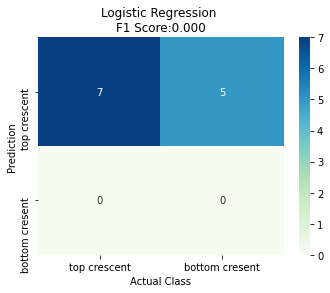

In [116]:
# plot figure
plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, cmap="GnBu", annot=True)

#add titles and labels for the axes
plt.title('Logistic Regression \nF1 Score:{0:.3f}'.format(f1_score(y_test, y_pred)))
plt.ylabel('Prediction')
plt.xlabel('Actual Class')
plt.show()

In [117]:
#logistic regression for inflation rate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import seaborn as sns
#world inflation rate in 2019 was  3.56%
bi = []
for i in df['inflation_rate']:
    if i >= 0.00356:
        bi.append(1)
    else:
        bi.append(0)
df['binary']=bi
X=df[['new_case_rate','death_rate']]    
y=df['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=42)
clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(y_pred) 
f1 = f1_score(y_test, y_pred) 
print('f1 score is = ' + str(f1))

[0 0 0 0 0 0 0 0 0 1 0 0]
f1 score is = 0.6666666666666666


tn: 10 
fp: 0 
fn: 1 
tp: 1


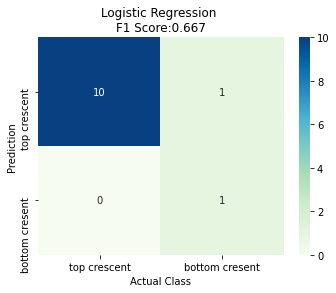

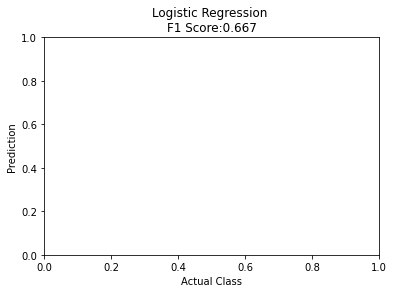

In [118]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#confusion matrix
import sklearn.metrics as skm
tn, fp, fn, tp = skm.confusion_matrix(y_test, y_pred).ravel()
print("tn:",tn, "\nfp:",fp, "\nfn:",fn, "\ntp:",tp)

cm = confusion_matrix(y_pred, y_test) 

labels = ['top crescent', 'bottom cresent']
df_cm = pd.DataFrame(cm,
                     index = labels, 
                     columns = labels)


plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, cmap="GnBu", annot=True)

plt.title('Logistic Regression \nF1 Score:{0:.3f}'.format(f1_score(y_test, y_pred)))
plt.ylabel('Prediction')
plt.xlabel('Actual Class')
plt.show()
plt.title('Logistic Regression \nF1 Score:{0:.3f}'.format(f1_score(y_test, y_pred)))
plt.ylabel('Prediction')
plt.xlabel('Actual Class')
plt.show()

tn: 10 
fp: 0 
fn: 1 
tp: 1


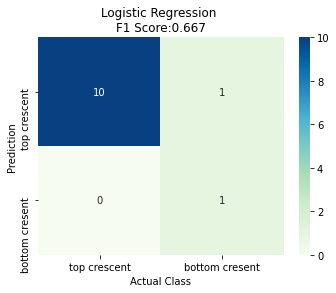

In [119]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#confusion matrix
import sklearn.metrics as skm
tn, fp, fn, tp = skm.confusion_matrix(y_test, y_pred).ravel()
print("tn:",tn, "\nfp:",fp, "\nfn:",fn, "\ntp:",tp)

cm = confusion_matrix(y_pred, y_test) 

labels = ['top crescent', 'bottom cresent']
df_cm = pd.DataFrame(cm,
                     index = labels, 
                     columns = labels)


plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, cmap="GnBu", annot=True)

plt.title('Logistic Regression \nF1 Score:{0:.3f}'.format(f1_score(y_test, y_pred)))
plt.ylabel('Prediction')
plt.xlabel('Actual Class')
plt.show()

Area Under Curve: 0.79


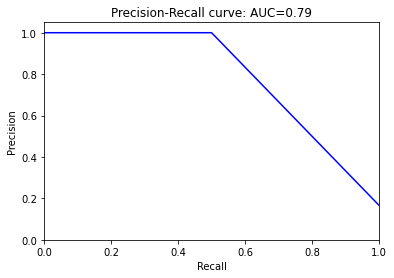

In [120]:
#Precision-recall curve
precision_prc, recall_prc, thresholds = skm.precision_recall_curve(y_test, y_pred, pos_label=1)
prc_auc = skm.auc(recall_prc, precision_prc)
print("Area Under Curve: %0.2f" % prc_auc)
plt.plot(recall_prc, precision_prc, 'b', label='Precision-Recall curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AUC=%0.2f' % prc_auc)
plt.show()

Area Under Curve: 0.750


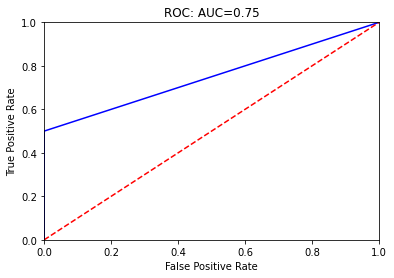

In [121]:
#ROC-AUC curve
fpr, tpr, threshold = skm.roc_curve(y_test, y_pred, pos_label=1)
roc_auc = skm.auc(fpr, tpr)
print('Area Under Curve: %0.3f' % roc_auc)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC: AUC=%0.2f' % roc_auc)
plt.show()

In [122]:
#ARMA test 
import pandas as pd
import matplotlib.pyplot as plt
gdp=pd.read_csv('G:\COVID-19 Economy/gdp_growth_rate.csv',index_col=0)
gdp.index=pd.date_range('1980','2022',freq='Y')
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    print("\n>>> Is",series.name, "stationary?")
    dftest = adfuller(series, autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {:.3f} - The data is {}stationary with {}% confidence".format(
            k.ljust(4), v, "not " if v<dftest[0] else "", 100-int(k[:-1])))
adf_test(gdp["India"])


>>> Is India stationary?
Test statistic = -6.126
P-value = 0.000
Critical values :
	1%  : -3.601 - The data is stationary with 99% confidence
	5%  : -2.935 - The data is stationary with 95% confidence
	10% : -2.606 - The data is stationary with 90% confidence


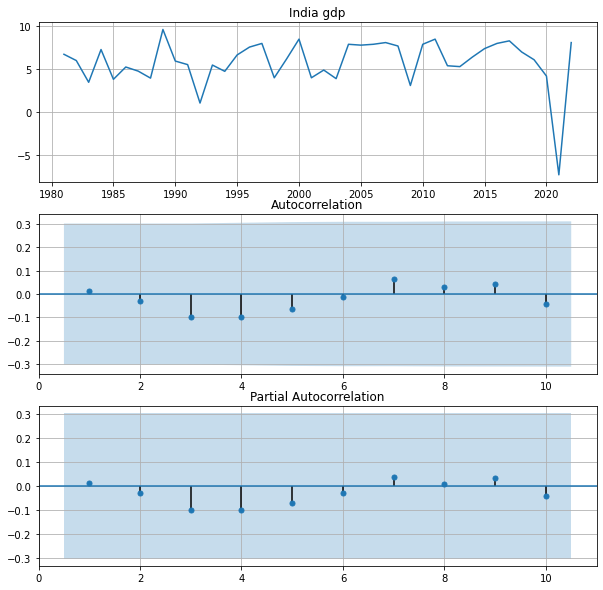

In [123]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
plt.subplots(3,1,figsize=(10,10))
ax = plt.subplot(3,1,1)
plt.grid()
plt.plot(gdp["India"])
plt.title("India gdp")
ax = plt.subplot(3,1,2)
plt.grid()
plot_acf(gdp["India"],ax, lags=10, zero=False)
ax = plt.subplot(3,1,3)
plt.grid()
plot_pacf(gdp["India"], method="ldb", zero=False, ax=ax, lags=10)
plt.show()
#got white noise so no way to predict by using ARMA

[[ 5.76325873 -0.10375226  0.55634728  1.35603409  2.70530225]
 [ 5.82858886  0.99759961  1.84552262  2.34465847  2.6346015 ]
 [ 5.86100156  0.79996353  1.88710332  2.20248911  2.67327116]]


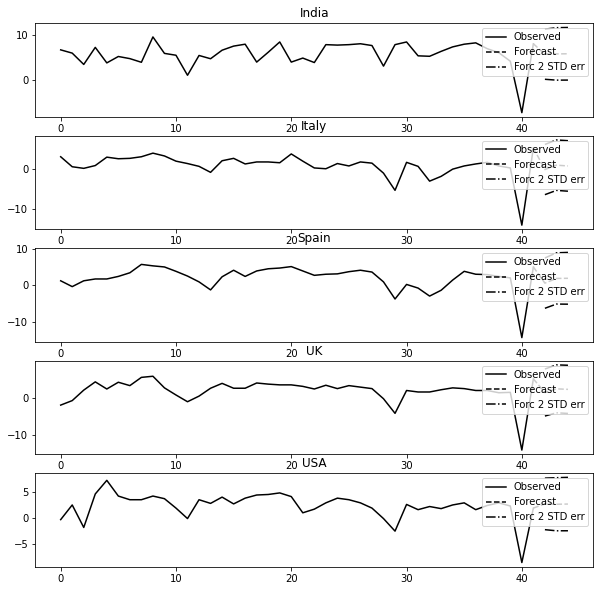

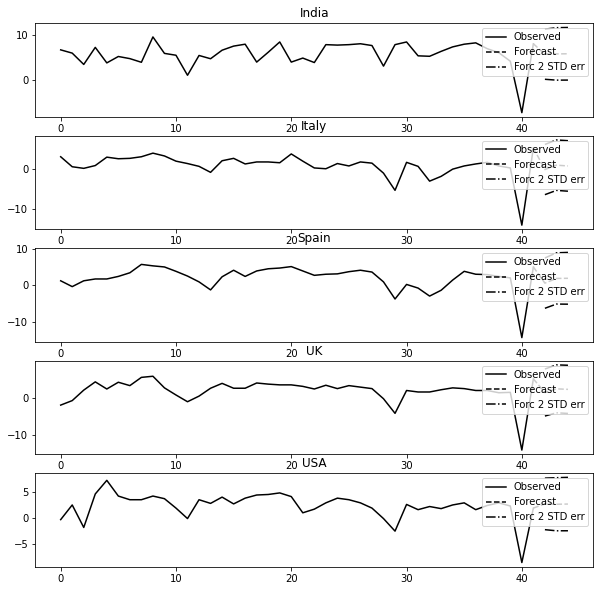

In [124]:
#VAR projection
from statsmodels.tsa.api import VAR
dates=gdp.index

model = VAR(endog=gdp,dates=dates)
model_fit = model.fit()
model_fit.summary()

lag_order = model_fit.k_ar

print(model_fit.forecast(gdp.values[-lag_order:],3))
model_fit.plot_forecast(3)

In [44]:
#Pda Classification
